**HOG**

In [0]:
#!/usr/local/bin/python3
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import time as t
from skimage.feature import hog, BRIEF
import re
from struct import *
from google.colab.patches import cv2_imshow

RATIO = 6

In [0]:
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Adirondack-perfect.zip
!unzip Adirondack-perfect.zip

--2020-03-13 17:09:21--  http://vision.middlebury.edu/stereo/data/scenes2014/zip/Adirondack-perfect.zip
Resolving vision.middlebury.edu (vision.middlebury.edu)... 140.233.20.14
Connecting to vision.middlebury.edu (vision.middlebury.edu)|140.233.20.14|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102406251 (98M) [application/zip]
Saving to: ‘Adirondack-perfect.zip’

Adirondack-perfect. 100%[===================>]  97.66M  57.2MB/s    in 1.7s    

2020-03-13 17:09:23 (57.2 MB/s) - ‘Adirondack-perfect.zip’ saved [102406251/102406251]

Archive:  Adirondack-perfect.zip
  inflating: Adirondack-perfect/calib.txt  
  inflating: Adirondack-perfect/disp0-n.pgm  
  inflating: Adirondack-perfect/disp0.pfm  
  inflating: Adirondack-perfect/disp0-sd.pfm  
  inflating: Adirondack-perfect/disp1-n.pgm  
  inflating: Adirondack-perfect/disp1.pfm  
  inflating: Adirondack-perfect/disp1-sd.pfm  
  inflating: Adirondack-perfect/im0.png  
  inflating: Adirondack-perfect/im1E.png  


In [0]:
def load_gt(gt_name):
  with open(gt_name,"rb") as f:
      # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
      type=f.readline().decode('latin-1')
      if "PF" in type:
          channels=3
      elif "Pf" in type:
          channels=1
      else:
          print("ERROR: Not a valid PFM file",file=sys.stderr)
          sys.exit(1)
      # Line 2: width height
      line=f.readline().decode('latin-1')
      width,height=re.findall('\d+',line)
      width=int(width)
      height=int(height)

      # Line 3: +ve number means big endian, negative means little endian
      line=f.readline().decode('latin-1')
      BigEndian=True
      if "-" in line:
          BigEndian=False

      # Slurp all binary data
      samples = width*height*channels;
      buffer  = f.read(samples*4)

      # Unpack floats with appropriate endianness
      if BigEndian:
          fmt=">"
      else:
          fmt="<"
      fmt= fmt + str(samples) + "f"
      img = unpack(fmt,buffer)
      gt = np.flip((np.array(img)).reshape( height, width), axis = 0)
  return gt


In [0]:
def apply_hog(image, descriptor_size, num_orientations, block_size):
    """
    computes HOG descriptor on both images.
    :param descriptor_size: number of pixels in a hog cell.
    :param num_orientations: number of HOG orientations.
    :return: (H x W x M) array, H = height, W = width and M = num_orientations, of type np.float32.
    """
    desc = hog(image,orientations=num_orientations,pixels_per_cell=(descriptor_size,descriptor_size), cells_per_block= (block_size,block_size),block_norm='L2',feature_vector=False)
    shape = desc.shape
    desc = desc.reshape([shape[0], shape[1], -1])
    # descriptor = np.zeros((shape[0]*shape[2],shape[1]*shape[3],shape[4]))
    # for iB in range(shape[2]):
    #   for iC in range(shape[3]):
    #     for jB in range(shape[1]):
    #       for jC in range(shape[3]):
    #         descriptor[iB*shape[2]+iC,jB*shape[3]+jC] = desc[iB,jB,iC,jC]
    return desc

def apply_brief(image, descriptor_size, num_elements, keypoints):
    """
    computes BRIEF descriptor on both images.
    :param descriptor_size: size of window of the BRIEF descriptor.
    :param num_elements: length of the feature vector.
    :return: (H x W) array, H = height and W = width, of type np.int64
    """
    keypointscp = keypoints.copy()
    desc = BRIEF(descriptor_size=num_elements, patch_size=descriptor_size)
    desc.extract(image,keypoints)
    #récupération des descripteurs (tableau de booléens)
   # (image.shape[0]//10 - 1 + (2  - descriptor_size)//10,image.shape[1]//10 - 1 + (2  - descriptor_size)//10
    descriptors = ((desc.descriptors).copy()).reshape(((image.shape[0] - descriptor_size + 1)//RATIO,(image.shape[1] - descriptor_size + 1)//RATIO, num_elements))
    return descriptors

In [0]:
im = cv2.imread("Adirondack-perfect/im0.png",0)
print(im.shape)
#print(apply_hog(im,5,8).shape)
#print(apply_brief(im,16,32).shape)

(1988, 2880)


In [0]:
def hamming_distance(left_descriptor, right_descriptor):
    left_xor = np.int64(np.bitwise_xor(left_descriptor, right_descriptor))
    #la distance de hamming correspond au nombre d'éléments non nuls après application d'un xor
    left_distance = np.count_nonzero(left_xor , axis = 2)
    
    
    #while not np.all(left_xor == 0):
    #    tmp = left_xor - 1
    #    mask = left_xor != 0
    #    left_xor[mask] = np.bitwise_and(left_xor[mask], tmp[mask])
    #    left_distance[mask] = left_distance[mask] + 1

    return left_distance


def l2_distance(left_descriptor, right_descriptor):
    return np.sum((left_descriptor - right_descriptor) ** 2.0, axis=2)



def get_recall(disparity, gt, max_disp):
    """
    computes the recall of the disparity map.
    :param disparity: disparity image.
    :param gt: path to ground-truth image.
    :param max_disp: maximum disparity.
    :return: rate of correct predictions.
    """
    gt = load_gt(gt)
    gt = np.where(gt==float('inf'), 255, gt) 
    std_gt = ((gt - np.ones(gt.shape)*np.mean(gt) )/ np.std(gt))
    std_disparity = ((disparity - np.ones(gt.shape)*np.mean(disparity))/np.std(disparity))
    correct = np.count_nonzero(np.abs(std_disparity - std_gt) <= 1)
    return float(correct) / gt.size

In [0]:


class Direction:
    def __init__(self, direction=(0, 0), name='invalid'):
        """
        represent a cardinal direction in image coordinates (top left = (0, 0) and bottom right = (1, 1)).
        :param direction: (x, y) for cardinal direction.
        :param name: common name of said direction.
        """
        self.direction = direction
        self.name = name


# 8 defined directions for sgm
N = Direction(direction=(0, -1), name='north')
NE = Direction(direction=(1, -1), name='north-east')
E = Direction(direction=(1, 0), name='east')
SE = Direction(direction=(1, 1), name='south-east')
S = Direction(direction=(0, 1), name='south')
SW = Direction(direction=(-1, 1), name='south-west')
W = Direction(direction=(-1, 0), name='west')
NW = Direction(direction=(-1, -1), name='north-west')


class Paths:
    def __init__(self):
        """
        represent the relation between the directions.
        """
        self.paths = [N, NE, E, SE, S, SW, W, NW]
        self.size = len(self.paths)
        self.effective_paths = [(E,  W), (SE, NW), (S, N), (SW, NE)]


class Parameters:
    def __init__(self, max_disparity=64, P1=5, P2=70, csize=(7, 7), bsize=(3, 3)):
        """
        represent all parameters used in the sgm algorithm.
        :param max_disparity: maximum distance between the same pixel in both images.
        :param P1: penalty for disparity difference = 1
        :param P2: penalty for disparity difference > 1
        :param csize: size of the kernel for the census transform.
        :param bsize: size of the kernel for blurring the images and median filtering.
        """
        self.max_disparity = max_disparity
        self.P1 = P1
        self.P2 = P2
        self.csize = csize
        self.bsize = bsize


def load_image(image_name, parameters):
    """
    read and blur stereo image.
    :param image_name: name of the left image.
    :param parameters: structure containing parameters of the algorithm.
    :return: blurred image.
    """
    image = cv2.imread(image_name, 0)
    image = cv2.GaussianBlur(image, parameters.bsize, 0, 0)
    return image


def get_indices(offset, dim, direction, height):
    """
    for the diagonal directions (SE, SW, NW, NE), return the array of indices for the current slice.
    :param offset: difference with the main diagonal of the cost volume.
    :param dim: number of elements along the path.
    :param direction: current aggregation direction.
    :param height: H of the cost volume.
    :return: arrays for the y (H dimension) and x (W dimension) indices.
    """
    y_indices = []
    x_indices = []

    for i in range(0, dim):
        if direction == SE.direction:
            if offset < 0:
                y_indices.append(-offset + i)
                x_indices.append(0 + i)
            else:
                y_indices.append(0 + i)
                x_indices.append(offset + i)

        if direction == SW.direction:
            if offset < 0:
                y_indices.append(height + offset - i)
                x_indices.append(0 + i)
            else:
                y_indices.append(height - i)
                x_indices.append(offset + i)

    return np.array(y_indices), np.array(x_indices)


def get_path_cost(slice, offset, parameters):
    """
    part of the aggregation step, finds the minimum costs in a D x M slice (where M = the number of pixels in the
    given direction)
    :param slice: (M x D) array from the cost volume.
    :param offset: ignore the pixels on the border.
    :param parameters: structure containing parameters of the algorithm.
    :return: (M x D) array of the minimum costs for a given slice in a given direction.
    """
    other_dim = slice.shape[0]
    disparity_dim = slice.shape[1]

    disparities = [d for d in range(disparity_dim)] * disparity_dim
    disparities = np.array(disparities).reshape(disparity_dim, disparity_dim)

    penalties = np.zeros(shape=(disparity_dim, disparity_dim), dtype=slice.dtype)
    penalties[np.abs(disparities - disparities.T) == 1] = parameters.P1
    penalties[np.abs(disparities - disparities.T) > 1] = parameters.P2

    minimum_cost_path = np.zeros(shape=(other_dim, disparity_dim), dtype=slice.dtype)
    minimum_cost_path[offset - 1, :] = slice[offset - 1, :]

    for i in range(offset, other_dim):
        previous_cost = minimum_cost_path[i - 1, :]
        current_cost = slice[i, :]
        costs = np.repeat(previous_cost, repeats=disparity_dim, axis=0).reshape(disparity_dim, disparity_dim)
        costs = np.amin(costs + penalties, axis=0)
        minimum_cost_path[i, :] = current_cost + costs - np.amin(previous_cost)
    return minimum_cost_path


def aggregate_costs(cost_volume, parameters, paths):
    """
    second step of the sgm algorithm, aggregates matching costs for N possible directions (8 in this case).
    :param cost_volume: array containing the matching costs.
    :param parameters: structure containing parameters of the algorithm.
    :param paths: structure containing all directions in which to aggregate costs.
    :return: (H x W x D x N) array of matching cost for all defined directions.
    """
    height = cost_volume.shape[0]
    width = cost_volume.shape[1]
    disparities = cost_volume.shape[2]
    start = -(height - 1)
    end = width - 1

    aggregation_volume = np.zeros(shape=(height, width, disparities, paths.size), dtype=cost_volume.dtype)

    path_id = 0
    for path in paths.effective_paths:
        print('\tProcessing paths {} and {}...'.format(path[0].name, path[1].name), end='')
        sys.stdout.flush()
        dawn = t.time()

        main_aggregation = np.zeros(shape=(height, width, disparities), dtype=cost_volume.dtype)
        opposite_aggregation = np.copy(main_aggregation)

        main = path[0]
        if main.direction == S.direction:
            for x in range(0, width):
                south = cost_volume[0:height, x, :]
                north = np.flip(south, axis=0)
                main_aggregation[:, x, :] = get_path_cost(south, 1, parameters)
                opposite_aggregation[:, x, :] = np.flip(get_path_cost(north, 1, parameters), axis=0)

        if main.direction == E.direction:
            for y in range(0, height):
                east = cost_volume[y, 0:width, :]
                west = np.flip(east, axis=0)
                main_aggregation[y, :, :] = get_path_cost(east, 1, parameters)
                opposite_aggregation[y, :, :] = np.flip(get_path_cost(west, 1, parameters), axis=0)

        if main.direction == SE.direction:
            for offset in range(start, end):
                south_east = cost_volume.diagonal(offset=offset).T
                north_west = np.flip(south_east, axis=0)
                dim = south_east.shape[0]
                y_se_idx, x_se_idx = get_indices(offset, dim, SE.direction, None)
                y_nw_idx = np.flip(y_se_idx, axis=0)
                x_nw_idx = np.flip(x_se_idx, axis=0)
                main_aggregation[y_se_idx, x_se_idx, :] = get_path_cost(south_east, 1, parameters)
                opposite_aggregation[y_nw_idx, x_nw_idx, :] = get_path_cost(north_west, 1, parameters)

        if main.direction == SW.direction:
            for offset in range(start, end):
                south_west = np.flipud(cost_volume).diagonal(offset=offset).T
                north_east = np.flip(south_west, axis=0)
                dim = south_west.shape[0]
                y_sw_idx, x_sw_idx = get_indices(offset, dim, SW.direction, height - 1)
                y_ne_idx = np.flip(y_sw_idx, axis=0)
                x_ne_idx = np.flip(x_sw_idx, axis=0)
                main_aggregation[y_sw_idx, x_sw_idx, :] = get_path_cost(south_west, 1, parameters)
                opposite_aggregation[y_ne_idx, x_ne_idx, :] = get_path_cost(north_east, 1, parameters)

        aggregation_volume[:, :, :, path_id] = main_aggregation
        aggregation_volume[:, :, :, path_id + 1] = opposite_aggregation
        path_id = path_id + 2

        dusk = t.time()
        print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return aggregation_volume


def compute_costs(left_descriptor, right_descriptor, descriptor_size, distance, disparity, descriptor, block_size):
    print('\tComputing cost volume...', end='')
    height = left_descriptor.shape[0]
    width = left_descriptor.shape[1]
    x_offset = 0
    if descriptor == 'brief' :
      max_disp = disparity//RATIO
    else : 
      max_disp = disparity//(descriptor_size)
    sys.stdout.flush()
    dawn = t.time()
    left_cost_volume = np.zeros(shape=(height, width, max_disp))
    rvalues = np.zeros(shape=right_descriptor.shape, dtype=right_descriptor.dtype)
    for d in range(0, max_disp):
        rvalues[:, (x_offset + d):(width - x_offset)] = right_descriptor[:, x_offset:(width - d - x_offset)]
        dist = distance(left_descriptor, rvalues)
        left_cost_volume[:, :, d] = dist
    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return left_cost_volume


def select_disparity(aggregation_volume):
    """
    last step of the sgm algorithm, corresponding to equation 14 followed by winner-takes-all approach.
    :param aggregation_volume: (H x W x D x N) array of matching cost for all defined directions.
    :return: disparity image.
    """
    volume = np.sum(aggregation_volume, axis=3)
    disparity_map = np.argmin(volume, axis=2)
    return disparity_map


def normalize(volume, parameters):
    """
    transforms values from the range (0, 64) to (0, 255).
    :param volume: n dimension array to normalize.
    :param parameters: structure containing parameters of the algorithm.
    :return: normalized array.
    """
    return 255.0 * volume / parameters.max_disparity


def sgm(left_name, right_name, descriptor, distance, descriptor_size, num_elements, num_orientations, block_size, max_disp):
    """
    computes the disparity map for the left image, with a given descriptor.
    :param left_name: path to left image.
    :param right_name: path to right image.
    :param descriptor: name of the chosen descriptor.
    :param distance: distance function.
    :param descriptor_size: size of the descriptor.
    :param num_elements: length of the BRIEF vector.
    :param num_orientations: length of the HOG vector.
    :param max_disp: maximum disparity of the dataset.
    :return: (H x W) disparity map for the left image.
    """
    # you probably need to change parameters P1 and P2 depending on the method.
    parameters = Parameters()
    paths = Paths()

    left = load_image(left_name, parameters)
    right = load_image(right_name, parameters)
    h,w = left.shape
    keypoints = []
    for i in range(0, (h - descriptor_size +1)//RATIO):
      for j in range(0, (w -descriptor_size +1)//RATIO):
        keypoints.append([RATIO*i +descriptor_size//2+1,RATIO*j +descriptor_size//2+1])
    keypoints = np.array(keypoints)
    if descriptor == 'hog':
        left_descriptor = apply_hog(left, descriptor_size, num_orientations, block_size)
        right_descriptor = apply_hog(right, descriptor_size, num_orientations, block_size)
    elif descriptor == 'brief':
        left_descriptor = apply_brief(left, descriptor_size, num_elements, keypoints)
        right_descriptor = apply_brief(right, descriptor_size, num_elements, keypoints)
    else:
        print(f'Invalid descriptor name, choices are "brief", "hog".')
        exit(-1)

    print('\nStarting cost computation...')
    cost_volume = compute_costs(left_descriptor, right_descriptor, descriptor_size, distance, max_disp, descriptor, block_size)
    print('\nStarting aggregation computation...')
    aggregation_volume = aggregate_costs(cost_volume, parameters, paths)

    print('\nSelecting best disparities...')
    return np.uint8(normalize(select_disparity(aggregation_volume), parameters))


In [0]:
param = {
    "descriptor_size" : 16,
    "num_elements" : 256,
    "num_orientation" : 13,
    "block_size" : 3,
}


def eval(descriptor,left,right, gt_name, info_text, **param):
  text_file = open(info_text,"r") 
  lines = text_file.readlines()
  width = int(lines[4][6:])
  height = int(lines[5][7:])
  max_disp = int(lines[6][6:])
  text_file.close()

  descriptor_size = param["descriptor_size"]
  num_elements = param["num_elements"]
  num_orientation = param["num_orientation"]
  block_size = param["block_size"]

  if descriptor == 'brief':
      distance = hamming_distance
  else:
      distance = l2_distance

  disparity_map_part = sgm(left, right, descriptor, distance, descriptor_size, num_elements, num_orientation, block_size, max_disp)
  if descriptor == 'brief':
    disparity_map = np.zeros((height,width))
    for i in range(0, (height - descriptor_size +1)//RATIO):
      for j in range(0, (width -descriptor_size +1)//RATIO):
        disparity_map[RATIO*i-RATIO//2+descriptor_size//2:RATIO*i+RATIO//2+descriptor_size//2, RATIO*j-RATIO//2+descriptor_size//2:RATIO*j+RATIO//2+ descriptor_size//2] = disparity_map_part[i,j]
  else:
    print(disparity_map_part.shape)
    disparity_map = np.zeros((height,width))
    for i in range(0, height//descriptor_size  - block_size):
      for j in range(0,width//descriptor_size - block_size):
        disparity_map[i*(descriptor_size) + block_size:(i+1)*(descriptor_size) + block_size,j*(descriptor_size) + block_size:(j+1)*(descriptor_size) + block_size] = disparity_map_part[i,j]
  print('\nEvaluating left disparity map...')
  recall = get_recall(disparity_map, gt_name, max_disp)
  print('\tRecall = {:.2f}%'.format(recall * 100.0))
  return disparity_map, recall


  




Starting cost computation...
	Computing cost volume...	(done in 7.52s)

Starting aggregation computation...
	Processing paths east and west...	(done in 9.18s)
	Processing paths south-east and north-west...	(done in 9.43s)
	Processing paths south and north...	(done in 9.25s)
	Processing paths south-west and north-east...	(done in 9.43s)

Selecting best disparities...

Evaluating left disparity map...
	Recall = 80.30%


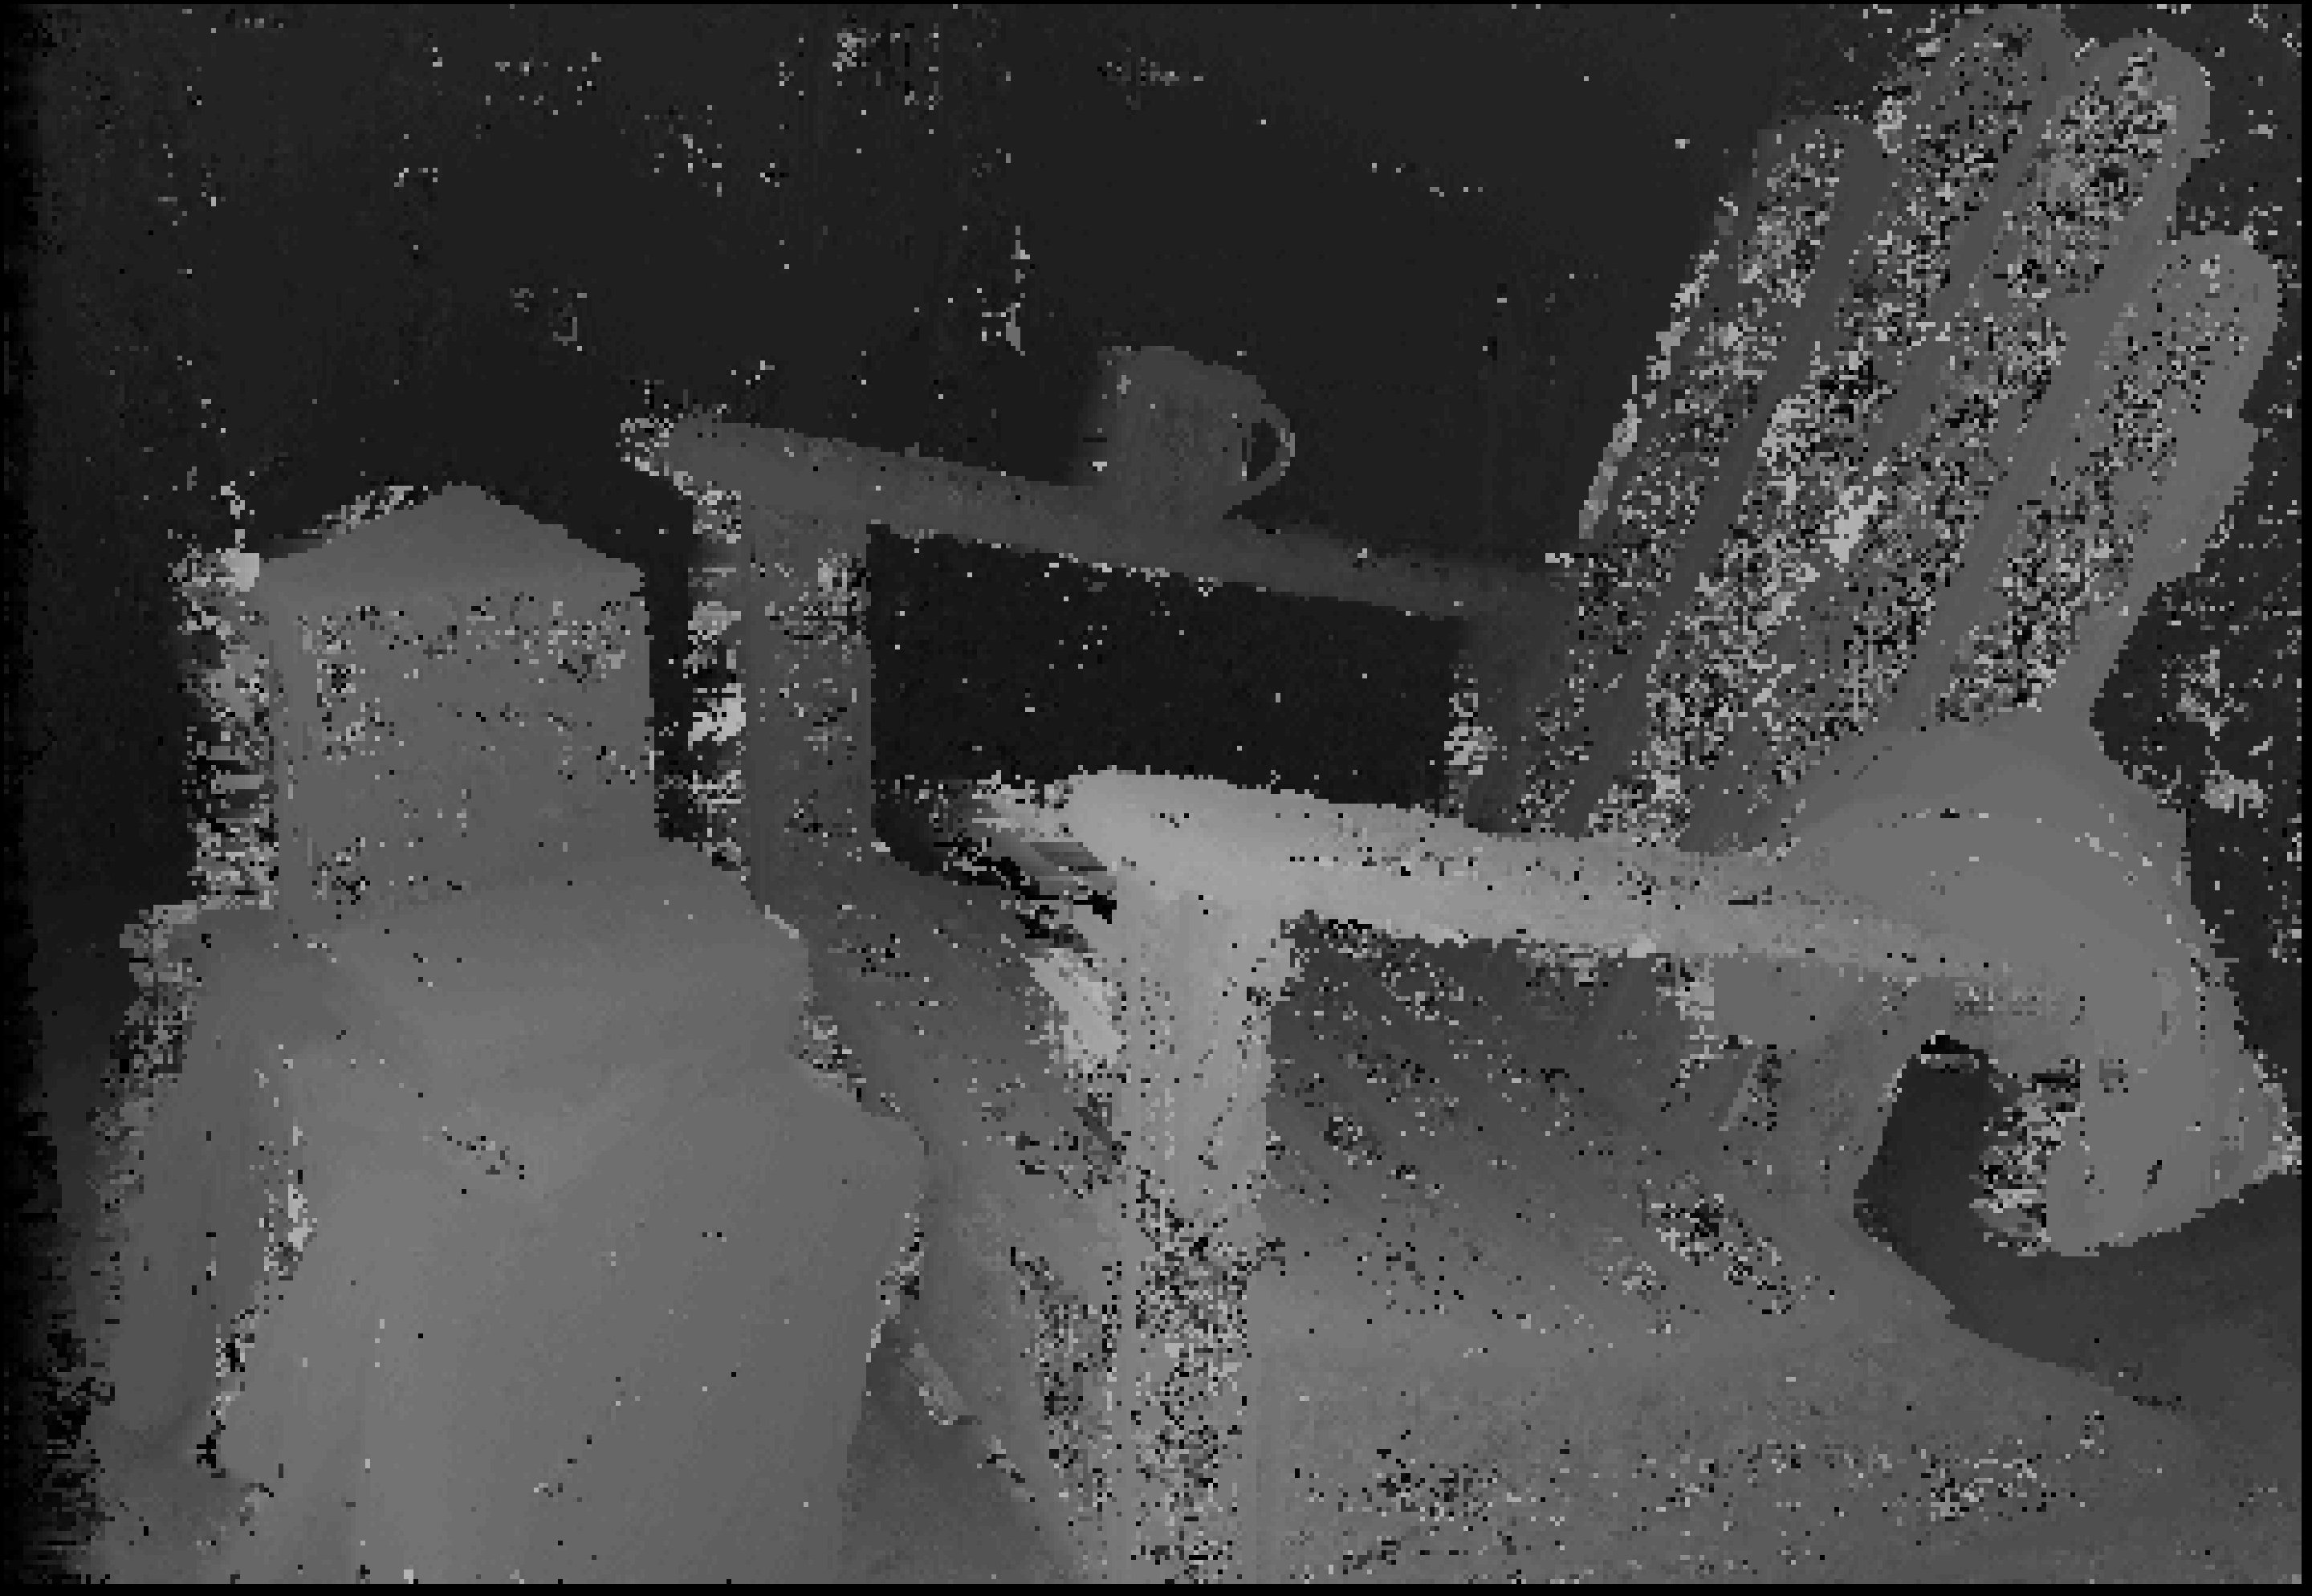

In [0]:
left = 'Adirondack-perfect/im0.png'
right = 'Adirondack-perfect/im1.png'
gt_name = 'Adirondack-perfect/disp1.pfm'
info_txt = "Adirondack-perfect/calib.txt"

param["descriptor_size"] = 16
param["num_elements"] = 256
disparity_map, _ = eval('brief',left,right,gt_name,info_txt,**param)
cv2_imshow(disparity_map)


Starting cost computation...
	Computing cost volume...	(done in 16.07s)

Starting aggregation computation...
	Processing paths east and west...	(done in 3.98s)
	Processing paths south-east and north-west...	(done in 4.20s)
	Processing paths south and north...	(done in 4.09s)
	Processing paths south-west and north-east...	(done in 4.18s)

Selecting best disparities...
(240, 352)

Evaluating left disparity map...
	Recall = 76.36%


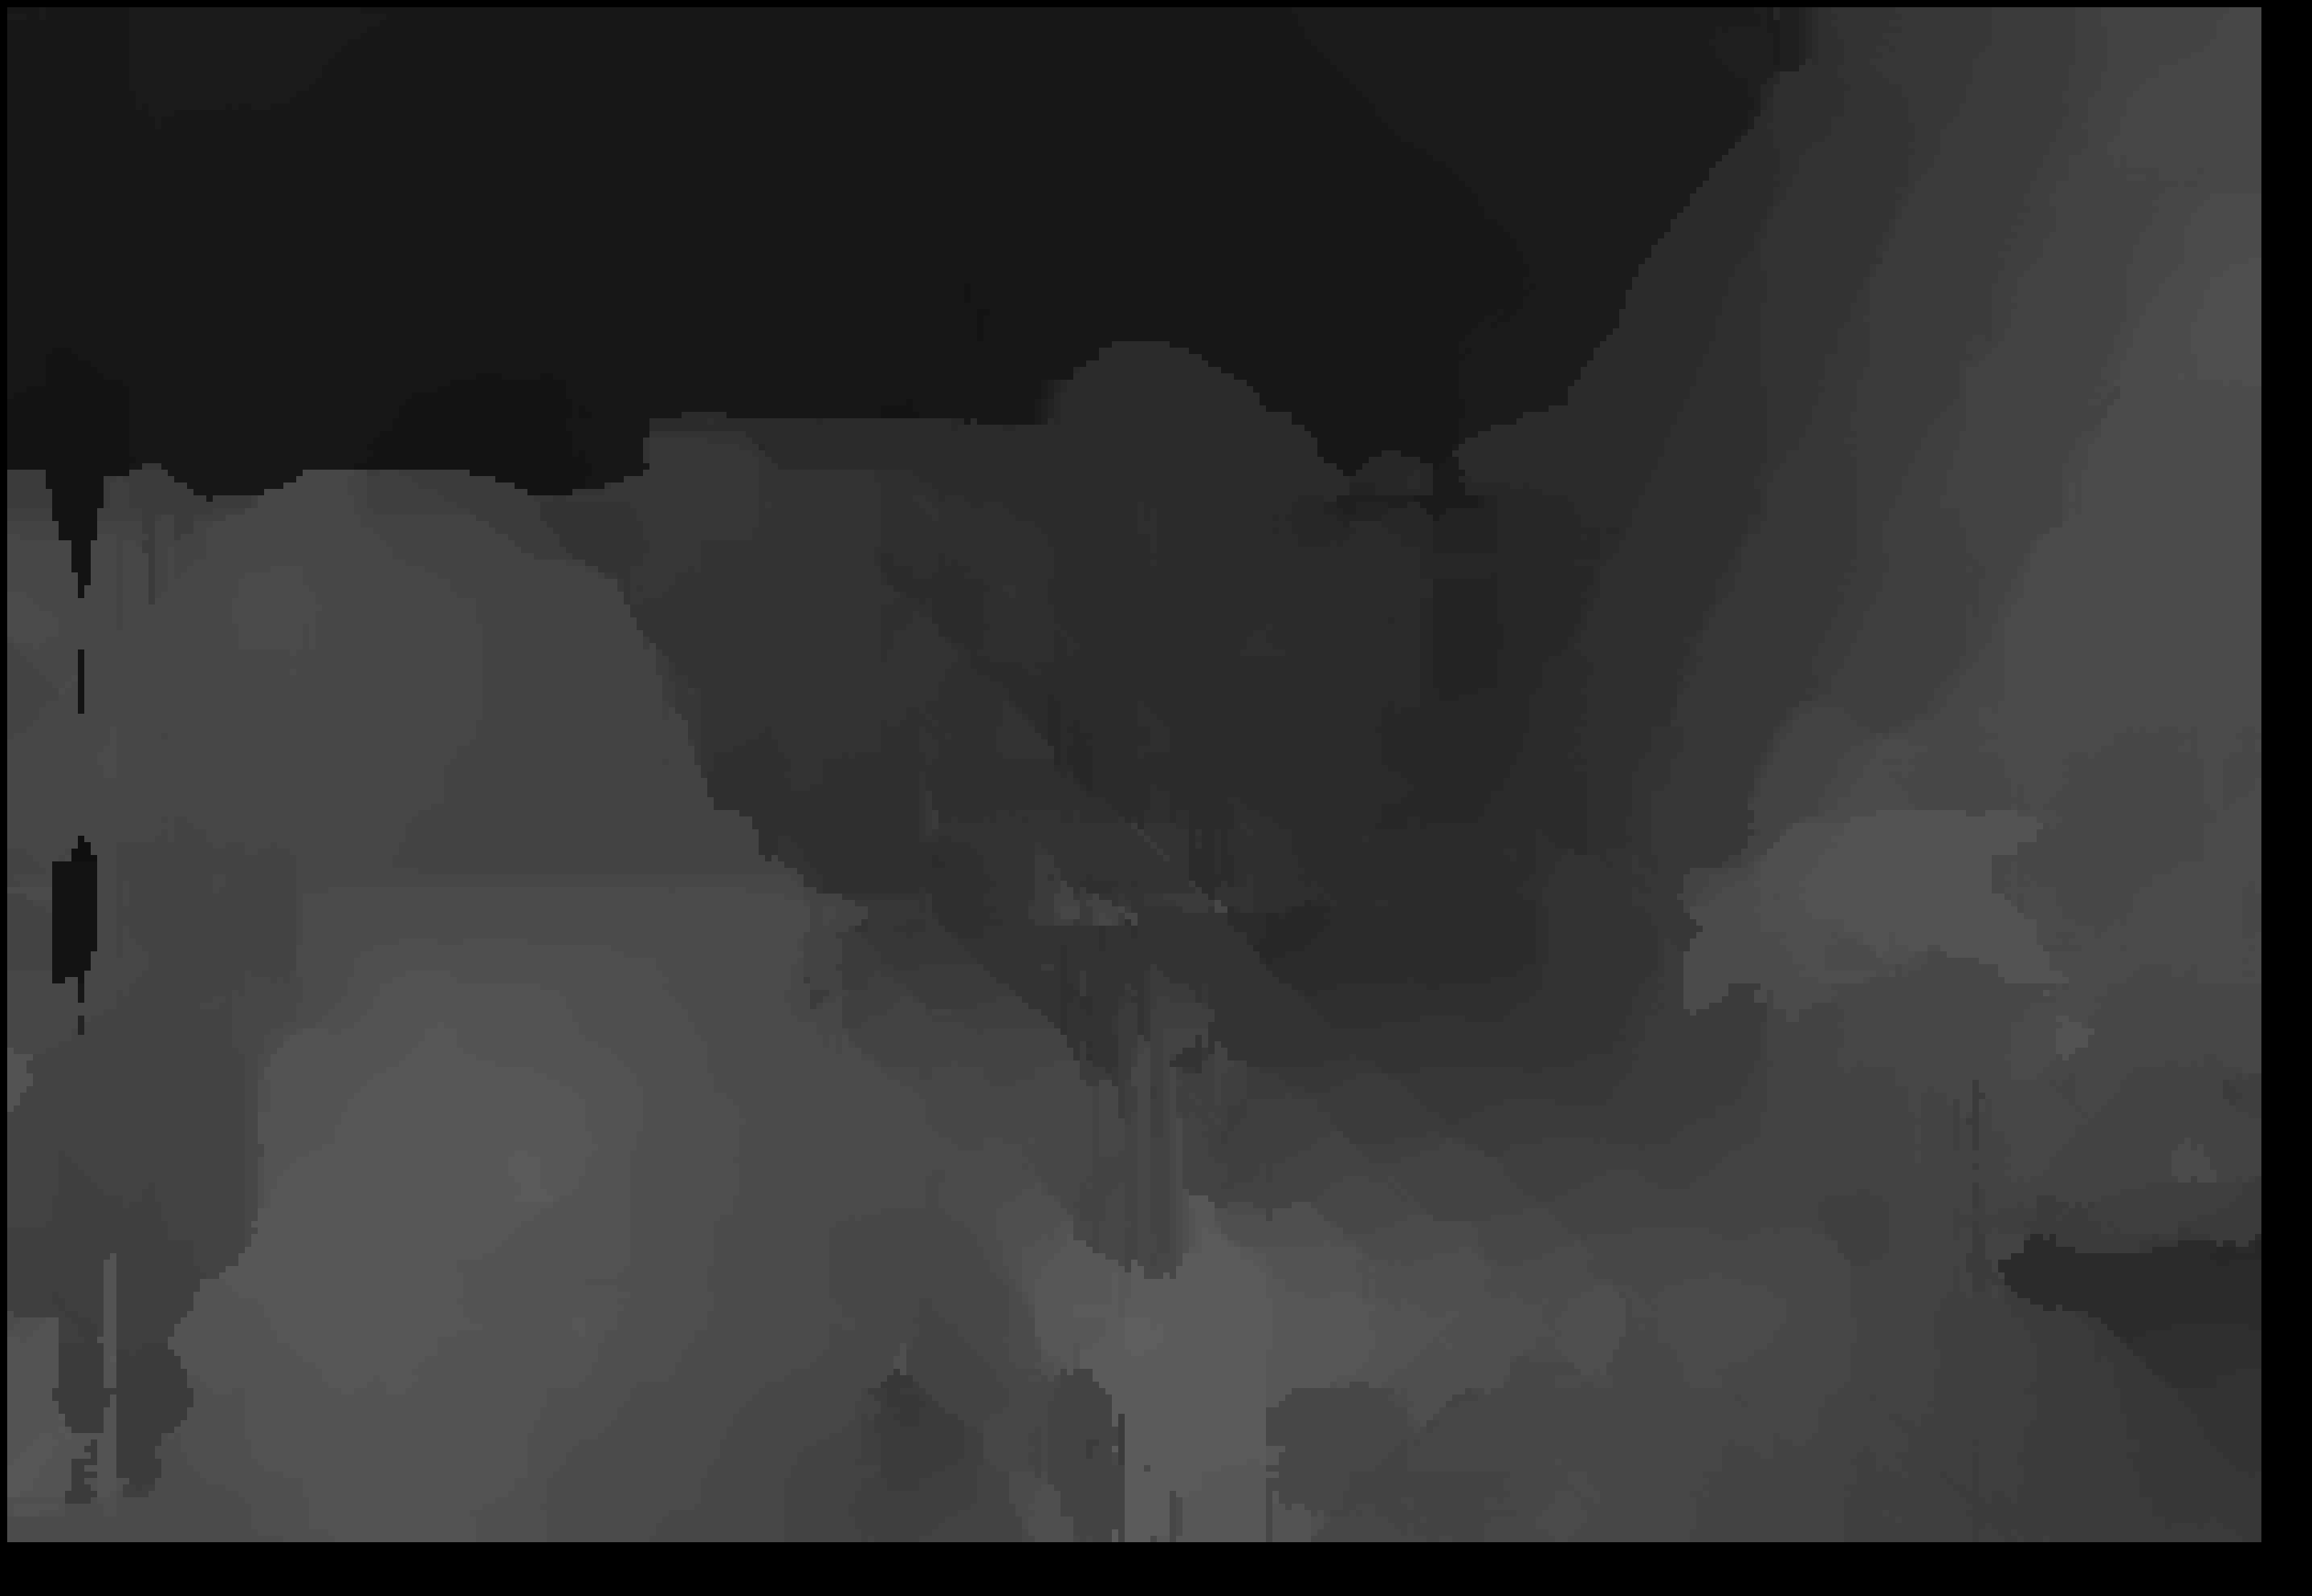

In [0]:
left = 'Adirondack-perfect/im0.png'
right = 'Adirondack-perfect/im1.png'
gt_name = 'Adirondack-perfect/disp1.pfm'
info_txt = "Adirondack-perfect/calib.txt"

param["descriptor_size"] = 8
param["num_orientation"] = 13
param["block_size"] = 9
disparity_map,_ = eval('hog',left,right,gt_name,info_txt,**param)
cv2_imshow(disparity_map)

In [0]:
left = 'Adirondack-perfect/im0.png'
right = 'Adirondack-perfect/im1.png'
gt_name = 'Adirondack-perfect/disp1.pfm'
info_txt = "Adirondack-perfect/calib.txt"

best_recall = 0
best_cell = 0
best_block = 0
best_nb_bin = 0
for cell in [8]:
  for block in [7,9,11]:
    for nb_bin in [8,12,13]:
      param["descriptor_size"] = cell
      param["num_orientation"] = nb_bin
      param["block_size"] = block
      disparity_map, recall = eval('hog',left,right,gt_name,info_txt,**param)
      if  recall > best_recall:
        best_recall = recall
        best_cell = cell
        best_block = block
        best_nb_bin = nb_bin



Starting cost computation...
	Computing cost volume...	(done in 6.56s)

Starting aggregation computation...
	Processing paths east and west...	(done in 4.04s)
	Processing paths south-east and north-west...	(done in 4.16s)
	Processing paths south and north...	(done in 4.10s)
	Processing paths south-west and north-east...	(done in 4.24s)

Selecting best disparities...
(242, 354)

Evaluating left disparity map...
	Recall = 77.02%

Starting cost computation...
	Computing cost volume...	(done in 9.81s)

Starting aggregation computation...
	Processing paths east and west...	(done in 4.06s)
	Processing paths south-east and north-west...	(done in 4.16s)
	Processing paths south and north...	(done in 4.19s)
	Processing paths south-west and north-east...	(done in 4.29s)

Selecting best disparities...
(242, 354)

Evaluating left disparity map...
	Recall = 76.98%

Starting cost computation...
	Computing cost volume...	(done in 10.71s)

Starting aggregation computation...
	Processing paths east and

In [0]:
print(best_nb_bin)
print(best_cell)
print(best_block)

13
8
7


In [0]:
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Bicycle1-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Cable-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Classroom1-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Couch-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Flowers-perfect.zip	 
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Jadeplant-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Mask-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Motorcycle-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Piano-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Pipes-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Playroom-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Playtable-perfect.zip 
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Recycle-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Shelves-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Shopvac-perfect.zip 
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Sticks-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Storage-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Sword1-perfect.zip	 
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Sword2-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Umbrella-perfect.zip
!wget http://vision.middlebury.edu/stereo/data/scenes2014/zip/Vintage-perfect.zip
!unzip '*.zip'

--2020-03-13 17:09:53--  http://vision.middlebury.edu/stereo/data/scenes2014/zip/Bicycle1-perfect.zip
Resolving vision.middlebury.edu (vision.middlebury.edu)... 140.233.20.14
Connecting to vision.middlebury.edu (vision.middlebury.edu)|140.233.20.14|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100820342 (96M) [application/zip]
Saving to: ‘Bicycle1-perfect.zip’

Bicycle1-perfect.zi 100%[===================>]  96.15M  27.6MB/s    in 5.6s    

2020-03-13 17:09:58 (17.0 MB/s) - ‘Bicycle1-perfect.zip’ saved [100820342/100820342]

--2020-03-13 17:09:59--  http://vision.middlebury.edu/stereo/data/scenes2014/zip/Cable-perfect.zip
Resolving vision.middlebury.edu (vision.middlebury.edu)... 140.233.20.14
Connecting to vision.middlebury.edu (vision.middlebury.edu)|140.233.20.14|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94056860 (90M) [application/zip]
Saving to: ‘Cable-perfect.zip’

Cable-perfect.zip   100%[===================>]  89.70M  14

In [0]:
param_brief = {
    "descriptor_size" : 16,
    "num_elements" : 256,
    "num_orientation" : 13,
    "block_size" : 3,
}

param_hog = {
    "descriptor_size" : 8,
    "num_elements" : 256,
    "num_orientation" : 13,
    "block_size" : 7,
}

recalls_hog = dict()
recalls_brief = dict()
times_hog = dict()
times_brief = dict()
names = [
        "Adirondack",
         "Bicycle1",
         "Cable",
         "Classroom1",
         "Couch",
         "Flowers",
         "Jadeplant",
         "Mask",
         "Motorcycle",
         "Piano",
         "Pipes",
         "Playroom",
         "Playtable",
         "Recycle",
         "Shelves",
         "Shopvac",
         "Sticks",
         "Storage",
         "Sword1",
         "Sword2",
         "Umbrella",
         "Vintage"
]
for name in names:
    print(name)
    dir = '{}-perfect/'.format(name)
    left = dir + 'im0.png'
    right = dir + 'im1.png'
    gt_name = dir + 'disp1.pfm'
    info_txt = dir + "calib.txt"
    start = t.time()
    disparity_map, recall = eval('hog',left,right,gt_name,info_txt,**param_hog)
    end = t.time()
    cv2.imwrite('{}-hog_left_disp_map.png'.format(name), disparity_map)
    recalls_hog[name] = recall
    times_hog[name] = end - start
    start = t.time()
    disparity_map, recall = eval('brief',left,right,gt_name,info_txt,**param_brief)
    end = t.time()
    cv2.imwrite('{}-brief_left_disp_map.png'.format(name), disparity_map)
    recalls_brief[name] = recall
    times_brief[name] = end - start

print(recalls_hog)
print(recalls_brief)

Adirondack

Starting cost computation...
	Computing cost volume...	(done in 12.64s)

Starting aggregation computation...
	Processing paths east and west...	(done in 6.06s)
	Processing paths south-east and north-west...	(done in 5.99s)
	Processing paths south and north...	(done in 5.87s)
	Processing paths south-west and north-east...	(done in 6.05s)

Selecting best disparities...
(242, 354)

Evaluating left disparity map...
	Recall = 77.24%

Starting cost computation...
	Computing cost volume...	(done in 10.44s)

Starting aggregation computation...
	Processing paths east and west...	(done in 12.65s)
	Processing paths south-east and north-west...	(done in 12.97s)
	Processing paths south and north...	(done in 12.97s)
	Processing paths south-west and north-east...	(done in 13.10s)

Selecting best disparities...

Evaluating left disparity map...
	Recall = 80.30%
Bicycle1

Starting cost computation...
	Computing cost volume...	(done in 8.27s)

Starting aggregation computation...
	Processing 

In [0]:
print(np.average(np.array(list(recalls_hog.values()))))
print(np.average(np.array(list(recalls_brief.values()))))
print(np.average(np.array(list(times_hog.values()))))
print(np.average(np.array(list(times_brief.values()))))

0.7617560189271142
0.7455993864014215
57.719614906744525
100.50319279323925


In [0]:
!zip disparity.zip *map.png 

In [0]:
param_brief = {
    "descriptor_size" : 50,
    "num_elements" : 1024,
    "num_orientation" : 13,
    "block_size" : 3,
}

param_hog = {
    "descriptor_size" : 30,
    "num_elements" : 256,
    "num_orientation" : 25,
    "block_size" : 11,
}

recalls_hog = dict()
recalls_brief = dict()
times_hog = dict()
times_brief = dict()
names = [
        "Adirondack",
         "Bicycle1",
         "Cable",
         "Classroom1",
         "Couch",
         "Flowers",
         "Jadeplant",
         "Mask",
         "Motorcycle",
         "Piano",
         "Pipes",
         "Playroom",
         "Playtable",
         "Recycle",
         "Shelves",
         "Shopvac",
         "Sticks",
         "Storage",
         "Sword1",
         "Sword2",
         "Umbrella",
         "Vintage"
]
for name in names:
    print(name)
    dir = '{}-perfect/'.format(name)
    left = dir + 'im0.png'
    right = dir + 'im1.png'
    gt_name = dir + 'disp1.pfm'
    info_txt = dir + "calib.txt"
    start = t.time()
    disparity_map, recall = eval('hog',left,right,gt_name,info_txt,**param_hog)
    end = t.time()
    cv2.imwrite('{}-hog_left_disp_map_wide.png'.format(name), disparity_map)
    recalls_hog[name] = recall
    times_hog[name] = end - start
    start = t.time()
    disparity_map, recall = eval('brief',left,right,gt_name,info_txt,**param_brief)
    end = t.time()
    cv2.imwrite('{}-brief_left_disp_map_wide.png'.format(name), disparity_map)
    recalls_brief[name] = recall
    times_brief[name] = end - start

print(recalls_hog)
print(recalls_brief)

Adirondack

Starting cost computation...
	Computing cost volume...	(done in 0.88s)

Starting aggregation computation...
	Processing paths east and west...	(done in 0.24s)
	Processing paths south-east and north-west...	(done in 0.26s)
	Processing paths south and north...	(done in 0.22s)
	Processing paths south-west and north-east...	(done in 0.25s)

Selecting best disparities...
(56, 86)

Evaluating left disparity map...
	Recall = 56.37%

Starting cost computation...
	Computing cost volume...	(done in 35.75s)

Starting aggregation computation...
	Processing paths east and west...	(done in 12.47s)
	Processing paths south-east and north-west...	(done in 12.71s)
	Processing paths south and north...	(done in 12.50s)
	Processing paths south-west and north-east...	(done in 12.74s)

Selecting best disparities...

Evaluating left disparity map...
	Recall = 81.72%
Bicycle1

Starting cost computation...
	Computing cost volume...	(done in 0.62s)

Starting aggregation computation...
	Processing pat

In [0]:
print(np.average(np.array(list(recalls_hog.values()))))
print(np.average(np.array(list(recalls_brief.values()))))
print(np.average(np.array(list(times_hog.values()))))
print(np.average(np.array(list(times_brief.values()))))

0.5348755582324117
0.7512712253324864
6.460475694049489
136.94126666675913


In [0]:
!zip disparity_wide.zip *map_wide.png 

  adding: Adirondack-brief_left_disp_map_wide.png (deflated 37%)
  adding: Adirondack-hog_left_disp_map_wide.png (deflated 88%)
  adding: Bicycle1-brief_left_disp_map_wide.png (deflated 39%)
  adding: Bicycle1-hog_left_disp_map_wide.png (deflated 91%)
  adding: Cable-brief_left_disp_map_wide.png (deflated 34%)
  adding: Cable-hog_left_disp_map_wide.png (deflated 86%)
  adding: Classroom1-brief_left_disp_map_wide.png (deflated 38%)
  adding: Classroom1-hog_left_disp_map_wide.png (deflated 90%)
  adding: Couch-brief_left_disp_map_wide.png (deflated 33%)
  adding: Couch-hog_left_disp_map_wide.png (deflated 87%)
  adding: Flowers-brief_left_disp_map_wide.png (deflated 34%)
  adding: Flowers-hog_left_disp_map_wide.png (deflated 89%)
  adding: Jadeplant-brief_left_disp_map_wide.png (deflated 35%)
  adding: Jadeplant-hog_left_disp_map_wide.png (deflated 84%)
  adding: Mask-brief_left_disp_map_wide.png (deflated 36%)
  adding: Mask-hog_left_disp_map_wide.png (deflated 86%)
  adding: Motorcycle

In [0]:
param_brief = {
    "descriptor_size" : 16,
    "num_elements" : 256,
    "num_orientation" : 13,
    "block_size" : 3,
}

param_hog = {
    "descriptor_size" : 8,
    "num_elements" : 256,
    "num_orientation" : 13,
    "block_size" : 7,
}

recalls_hog = dict()
recalls_brief = dict()
times_hog = dict()
times_brief = dict()
names = [
        "Adirondack",
         "Bicycle1",
         "Cable",
         "Classroom1",
         "Couch",
         "Flowers",
         "Jadeplant",
         "Mask",
         "Motorcycle",
         "Piano",
         "Pipes",
         "Playroom",
         "Playtable",
         "Recycle",
         "Shelves",
         "Shopvac",
         "Sticks",
         "Storage",
         "Sword1",
         "Sword2",
         "Umbrella",
         "Vintage"
]

def load_image(image_name, parameters):
    """
    redefine load_image to add noise to the images
    """
    image = cv2.imread(image_name, 0)
    noise = np.random.normal(0, 150,image.shape)
    image = image + noise
    return image


for name in names:
    print(name)
    dir = '{}-perfect/'.format(name)
    left = dir + 'im0.png'
    right = dir + 'im1.png'
    gt_name = dir + 'disp1.pfm'
    info_txt = dir + "calib.txt"
    start = t.time()
    disparity_map, recall = eval('hog',left,right,gt_name,info_txt,**param_hog)
    end = t.time()
    cv2.imwrite('{}-hog_left_disp_map_noise.png'.format(name), disparity_map)
    recalls_hog[name] = recall
    times_hog[name] = end - start
    start = t.time()
    disparity_map, recall = eval('brief',left,right,gt_name,info_txt,**param_brief)
    end = t.time()
    cv2.imwrite('{}-brief_left_disp_map_noise.png'.format(name), disparity_map)
    recalls_brief[name] = recall
    times_brief[name] = end - start

print(recalls_hog)
print(recalls_brief)

Adirondack

Starting cost computation...
	Computing cost volume...	(done in 12.47s)

Starting aggregation computation...
	Processing paths east and west...	(done in 6.10s)
	Processing paths south-east and north-west...	(done in 6.21s)
	Processing paths south and north...	(done in 6.12s)
	Processing paths south-west and north-east...	(done in 6.33s)

Selecting best disparities...
(242, 354)

Evaluating left disparity map...
	Recall = 61.46%

Starting cost computation...
	Computing cost volume...	(done in 9.61s)

Starting aggregation computation...
	Processing paths east and west...	(done in 13.06s)
	Processing paths south-east and north-west...	(done in 13.62s)
	Processing paths south and north...	(done in 13.45s)
	Processing paths south-west and north-east...	(done in 13.42s)

Selecting best disparities...

Evaluating left disparity map...
	Recall = 69.94%
Bicycle1

Starting cost computation...
	Computing cost volume...	(done in 8.37s)

Starting aggregation computation...
	Processing p

In [0]:
print(np.average(np.array(list(recalls_hog.values()))))
print(np.average(np.array(list(recalls_brief.values()))))
print(np.average(np.array(list(times_hog.values()))))
print(np.average(np.array(list(times_brief.values()))))

0.6538266523711032
0.6637861336146839
57.89480291713368
100.79366663369265


In [0]:
!zip disparity_noise.zip *map_noise.png 

  adding: Adirondack-brief_left_disp_map_noise.png (deflated 33%)
  adding: Adirondack-hog_left_disp_map_noise.png (deflated 43%)
  adding: Bicycle1-brief_left_disp_map_noise.png (deflated 36%)
  adding: Bicycle1-hog_left_disp_map_noise.png (deflated 48%)
  adding: Cable-brief_left_disp_map_noise.png (deflated 33%)
  adding: Cable-hog_left_disp_map_noise.png (deflated 38%)
  adding: Classroom1-brief_left_disp_map_noise.png (deflated 32%)
  adding: Classroom1-hog_left_disp_map_noise.png (deflated 48%)
  adding: Couch-brief_left_disp_map_noise.png (deflated 30%)
  adding: Couch-hog_left_disp_map_noise.png (deflated 46%)
  adding: Flowers-brief_left_disp_map_noise.png (deflated 30%)
  adding: Flowers-hog_left_disp_map_noise.png (deflated 40%)
  adding: Jadeplant-brief_left_disp_map_noise.png (deflated 31%)
  adding: Jadeplant-hog_left_disp_map_noise.png (deflated 39%)
  adding: Mask-brief_left_disp_map_noise.png (deflated 31%)
  adding: Mask-hog_left_disp_map_noise.png (deflated 45%)
  ad

In [0]:
for name in names:
    dir = '{}-perfect/'.format(name)
    gt_name = dir + 'disp1.pfm'
    gt = load_gt(gt_name)
    cv2.imwrite('{}-disparity_maps.png'.format(name), gt)


!zip disparity_maos.zip *disparity_maps.png 


  adding: Adirondack-disparity_maps.png (deflated 23%)
  adding: Bicycle1-disparity_maps.png (deflated 5%)
  adding: Cable-disparity_maps.png (deflated 12%)
  adding: Classroom1-disparity_maps.png (deflated 20%)
  adding: Couch-disparity_maps.png (deflated 21%)
  adding: Flowers-disparity_maps.png (deflated 5%)
  adding: Jadeplant-disparity_maps.png (deflated 8%)
  adding: Mask-disparity_maps.png (deflated 8%)
  adding: Motorcycle-disparity_maps.png (deflated 6%)
  adding: Piano-disparity_maps.png (deflated 23%)
  adding: Pipes-disparity_maps.png (deflated 11%)
  adding: Playroom-disparity_maps.png (deflated 20%)
  adding: Playtable-disparity_maps.png (deflated 23%)
  adding: Recycle-disparity_maps.png (deflated 22%)
  adding: Shelves-disparity_maps.png (deflated 14%)
  adding: Shopvac-disparity_maps.png (deflated 12%)
  adding: Sticks-disparity_maps.png (deflated 3%)
  adding: Storage-disparity_maps.png (deflated 13%)
  adding: Sword1-disparity_maps.png (deflated 4%)
  adding: Sword2-